In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

tmin, tave, tmax = np.ravel(calc_temps('2017-08-01','2017-08-07')[0])
print(tmin)
print(tave)
print(tmax)
print(tmax-tmin)

72.0
79.25
83.0
11.0


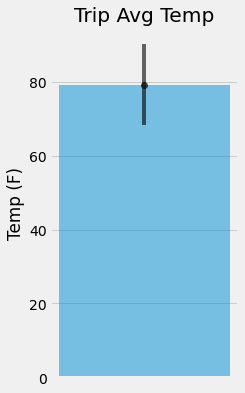

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

err = tmax-tmin
plt.figure(figsize=(3, 6))
plt.bar(1,tave,alpha=0.5)
plt.errorbar(x=1, y=tave,yerr=err, fmt="o", color="k",alpha=0.6)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])

plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station,Station.name, Station.latitude, Station.longitude, Station.elevation,\
              func.sum(Measurement.prcp).label("total_prcp")).group_by(Measurement.station)\
             .join(Station,Measurement.station == Station.station).order_by(desc(func.sum(Measurement.prcp))).all()
pd.DataFrame(rainfall)


,station,name,latitude,longitude,elevation,total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1068.09
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,588.64
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,382.62
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,295.68
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,234.49
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,131.62
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,92.68
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,70.87
8,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,43.44


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("08-01")

[(67.0, 75.54, 83.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
sd = dt.date(2017,8,1)
ed = dt.date(2017,8,7)
dr = [sd + dt.timedelta(days=x) for x in range(0,7)]
date_range = [str(d) for d in dr]

In [15]:
# Strip off the year and save a list of strings in the format %m-%d
month_range = [d[5:10] for d in date_range]
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [np.ravel(daily_normals(m)[0]) for m in month_range]

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals)
normals_df = normals_df.rename(columns = {0:'tmin',1:'tavg',2:'tmax'})
normals_df['date'] = date_range
normals_df = normals_df.set_index('date')
normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


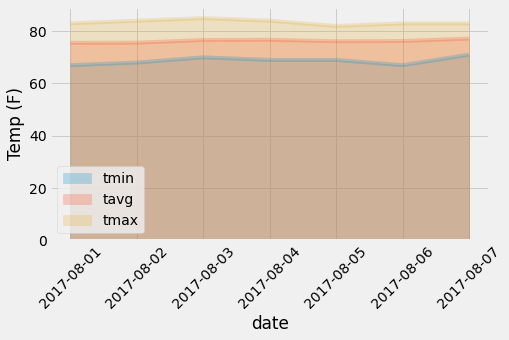

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False, rot=45,alpha = 0.25,figsize=(7,4),ylabel="Temp (F)")
plt.show()

## Close Session

In [18]:
session.close()